# Household Power Consumption

## Disclaimer

AI (ChatGPT) was user to help write this project, for both code and documentation. Any code generated has been studied, and any documentation has been verified.

### Dataset Download and Setup

Please download the dataset from [here](https://archive.ics.uci.edu/dataset/235/individual+household+electric+power+consumption) and extract the .txt file into the `electricity_usage` folder (where `main.ipynb` is located).

### About the Dataset

This dataset has taken "measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years."

The original format is in a `.txt` file, but should be easy enough to convert to something more workable like a `.csv` file.

The current headings are as follows:
1. date: Date in format dd/mm/yyyy
2. time: time in format hh:mm:ss
3. global_active_power: household global minute-averaged active power (in kilowatt)
4. global_reactive_power: household global minute-averaged reactive power (in kilowatt)
5. voltage: minute-averaged voltage (in volt)
6. global_intensity: household global minute-averaged current intensity (in ampere)
7. sub_metering_1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).
8. sub_metering_2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.
9. sub_metering_3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.

I am not entirely sure what the difference between **active** and **reactive** power is, and I cannot seem to find any documentation about it from the dataset source.

It could be assumed that the true total electricity usage is as follows: 
> `total_consumption = global_active_power + sub_metering_1 + sub_metering_2 + sub_metering_3`

### What can we do with this data?

Looking at the dataset, we could make predictions about whether or not we can expect higher power consumpution at a certain date and time. For example, you would probably use more power at 5PM in January vs. 6AM in August. We could make a simple decision tree model to make these predictions.

In [14]:
import pandas as pd
import numpy as np

""" 

Here I am trying to load the data from the file 'household_power_consumption.txt' into a pandas dataframe.
Since it is a .txt file, I am using the read_csv method of pandas to read the file and specifying the separator as ';'. I also specify the na_values as ['?', ''] to replace the missing values with NaN.

"""

try:
    df = pd.read_csv('household_power_consumption.txt', sep=';', na_values=['?', ''])
    print("Successfully loaded the data into a pandas dataframe!")
except FileNotFoundError:
    print('File not found')
    exit()

Successfully loaded the data into a pandas dataframe!


In [15]:
df.columns

Index(['Date', 'Time', 'Global_active_power', 'Global_reactive_power',
       'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')

That seems to have worked, now I want to convert all of the column headers to lowercase. 

Next Steps:
1. I want to convert the date and time columns into a datetime object and drop the original date and time columns.
2. Using this new datetime object, create the new `year`, `month`, `day`, `hour`, `day_of_week` and `quarter` features.
3. Create the `total_consumption` feature. 

In [16]:
# Convert all column headers to lowercase
df.columns = [col.lower() for col in df.columns]

# Convert date and time columns
df['date_time'] = pd.to_datetime(df['date'] + ' ' + df['time'], format='%d/%m/%Y %H:%M:%S', errors='coerce')

# Drop the original date and time columns
df = df.drop(['date', 'time'], axis=1)

# Handle missing values
df = df.replace({np.nan: 0})

# Creating new features from datetime object
df['year'] = df['date_time'].dt.year
df['month'] = df['date_time'].dt.month
df['day'] = df['date_time'].dt.day
df['hour'] = df['date_time'].dt.hour
df['day_of_week'] = df['date_time'].dt.dayofweek  # Monday=0, Sunday=6
df['quarter'] = df['date_time'].dt.quarter

# Calculate total consumption
df['total_consumption'] = df['global_active_power'] + df['sub_metering_1'] + df['sub_metering_2'] + df['sub_metering_3']

df.columns

Index(['global_active_power', 'global_reactive_power', 'voltage',
       'global_intensity', 'sub_metering_1', 'sub_metering_2',
       'sub_metering_3', 'date_time', 'year', 'month', 'day', 'hour',
       'day_of_week', 'quarter', 'total_consumption'],
      dtype='object')

The next step is to create the consumption categories of low, medium and high.

In [17]:
consumption_stats = df['total_consumption'].describe()
low_threshold = consumption_stats['25%']
high_threshold = consumption_stats['75%']

def categorize_consumption(consumption):
    if consumption < low_threshold:
        return 'low'
    elif consumption < high_threshold:
        return 'medium'
    else:
        return 'high'

df['consumption_category'] = df['total_consumption'].apply(categorize_consumption)

consumption_counts = df['consumption_category'].value_counts()
print(df.head())
print(consumption_counts)

   global_active_power  global_reactive_power  voltage  global_intensity  \
0                4.216                  0.418   234.84              18.4   
1                5.360                  0.436   233.63              23.0   
2                5.374                  0.498   233.29              23.0   
3                5.388                  0.502   233.74              23.0   
4                3.666                  0.528   235.68              15.8   

   sub_metering_1  sub_metering_2  sub_metering_3           date_time  year  \
0             0.0             1.0            17.0 2006-12-16 17:24:00  2006   
1             0.0             1.0            16.0 2006-12-16 17:25:00  2006   
2             0.0             2.0            17.0 2006-12-16 17:26:00  2006   
3             0.0             1.0            17.0 2006-12-16 17:27:00  2006   
4             0.0             1.0            17.0 2006-12-16 17:28:00  2006   

   month  day  hour  day_of_week  quarter  total_consumption  \
0   

## What do we want to predict off of?

I want to be able to predict how much power might be getting used based off of date and time alone, so it's important we modify the dataset before training the random forest classifier to allow for this.

## Prior to this point...

Before obtaining these results, I was all features except for the power classes to make predictions. This is not what I had in mind and had to be changed. With that model, the accuracy was far too high and was approaching overfitting. Some classes actually were overfit! For example:
- Achieved 0.87 precision and 0.99 recall for 'high' class.
- Achieved 0.99 precision and 1.00 recall for 'low' class.
- Achieved 1.00 precision and 0.92 recall for 'medium' class.

This was not ideal. I went and changed the X features to only be for time: `['year', 'month', 'day', 'hour', 'day_of_week', 'quarter']`. I also went and increased the `n_estimators` and `max_depth` since we now had far less data to work off of. This approach seemed to work. See final results below for more details.

## Final Results

After changing up the dataset a bit and modifying arguments on the random forest classifier, I was able to obtain an acceptable levels of accuracy, but not brilliant. However, I would rather have a slightly worse performing model over an overfit model. 

The overall accuracy of the model is `0.75`.
As for the classes:
```
        precision  recall    f1-score   support

high      0.70      0.88      0.78    104163
low       0.72      0.70      0.71    103561
medium    0.79      0.71      0.75    207328
```

Overall an acceptable result.

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Vectorized datetime conversion
datetime_columns = df.select_dtypes(include=['datetime64']).columns
for col in datetime_columns:
    # Create all date features at once using vectorized operations
    # Vectorized operations are preferred here because they are more efficient and faster than applying functions row by row.
    # This is especially important when dealing with large datasets, as it significantly reduces the computation time.
    # See more here: https://pythonspeed.com/articles/pandas-vectorization/
    df = df.assign(**{
        f'{col}_year': df[col].dt.year,
        f'{col}_month': df[col].dt.month,
        f'{col}_day': df[col].dt.day
    })

# Drop original datetime columns all at once
df = df.drop(columns=datetime_columns)

# Prepare features (X) and target (y)
X = df[['year', 'month', 'day', 'hour', 'day_of_week', 'quarter']]
y = df['consumption_category']

# Convert all features to float
X = X.astype(float)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize model with anti-overfitting parameters
rf_model = RandomForestClassifier(
    n_estimators=200,  # Reduced number of trees
    max_depth=20,      # Reduced depth
    min_samples_split=20,  # Increased min samples to split
    min_samples_leaf=10,   # Increased min samples per leaf
    max_features='sqrt',   # Restrict features per split
    random_state=748757,
    n_jobs=-1,
    class_weight='balanced'
)

# Train model
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=20,
                       min_samples_leaf=10, min_samples_split=20,
                       n_estimators=200, n_jobs=-1, random_state=748757)

In [39]:
# Evaluate
y_pred = rf_model.predict(X_test)
accuracy = rf_model.score(X_test, y_test)
print(f"Model accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)
print("\nTop 10 Important Features:")
print(feature_importance.head(10))

Model accuracy: 0.75

Classification Report:
              precision    recall  f1-score   support

        high       0.70      0.88      0.78    104163
         low       0.72      0.70      0.71    103561
      medium       0.79      0.71      0.75    207328

    accuracy                           0.75    415052
   macro avg       0.74      0.76      0.75    415052
weighted avg       0.75      0.75      0.75    415052


Top 10 Important Features:
       feature  importance
3         hour    0.418175
2          day    0.260400
0         year    0.102756
4  day_of_week    0.097564
1        month    0.094229
5      quarter    0.026876


# Confusion Matrix

The confusion matrix is showing that there is quite a few false positives, specifically for:
1. Predicted high, actually medium.
2. Predicted low, actually medium.
3. Predicted medium, actually low.
4. Predicted medium, actually high.

I have a slight suspicion this has something to do with the amount of medium classes vs low/high classes. There is roughly double the amount of medium classes compared to low/high. It might be biased towards medium.

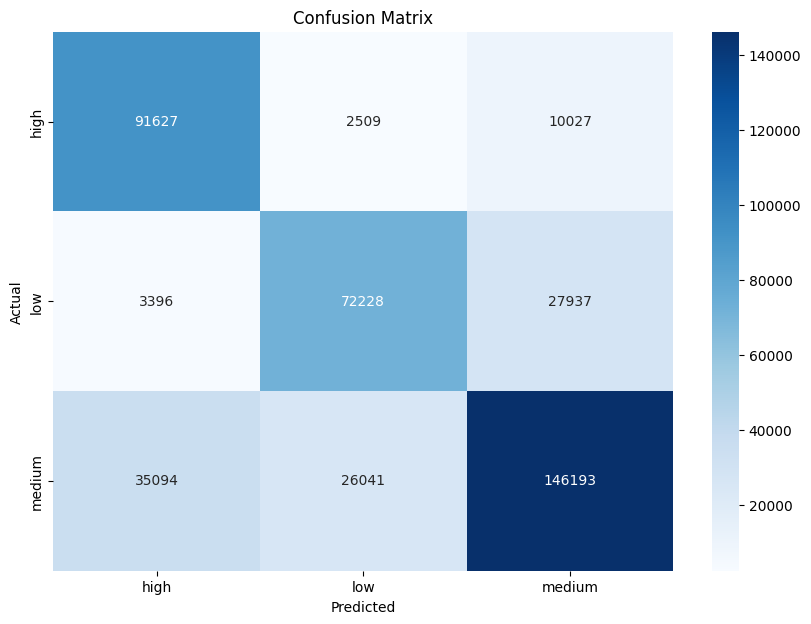

In [44]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Pretty print with seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Predictions

Predictions were made with three different samples. One during the summer at day time, one during the winter at night time and one during the summer at night time. You would expect it would be low, high, medium respectively. Luckily, our model correctly predicts this.

In [ ]:
# Make predictions
sample_data = pd.DataFrame({ # July 15, 2006, 12:00
    'year': [2006],
    'month': [7], 
    'day': [15],
    'hour': [12],
    'day_of_week': [3],
    'quarter': [2]
})

sample_data_2 = pd.DataFrame({ # December 25, 2006, 18:00
    'year': [2006],
    'month': [12], 
    'day': [25],
    'hour': [18],
    'day_of_week': [0],
    'quarter': [4]
})

sample_data_3 = pd.DataFrame({ # July 15, 2006, 22:00
    'year': [2006],
    'month': [7], 
    'day': [15],
    'hour': [22],
    'day_of_week': [3],
    'quarter': [2]
})

predictions = rf_model.predict(sample_data)
print("\nPredictions:")
print("Sample 1, July 15, 2006, 12:00: ", predictions)

predictions = rf_model.predict(sample_data_2)
print("Sample 2, December 25, 2006, 18:00: ", predictions)

predictions = rf_model.predict(sample_data_3)
print("Sample 3, July 15, 2006, 22:00: ", predictions)


Predictions:
Sample 1, July 15, 2006, 12:00:  ['low']
Sample 2, December 25, 2006, 18:00:  ['high']
Sample 3, July 15, 2006, 22:00:  ['medium']
